In [1]:
from netgen import gui
from math import pi
from ngsolve import *
from netgen.geom2d import SplineGeometry

import numpy as np
import scipy.sparse as sp
import matplotlib.pyplot as plt

from ngsolve.internal import visoptions

In [2]:
numsnap = 200
MaxTime = 2
Norm_Residium = []
iteration = int(100)
boundaries = "Dirichlet"

In [3]:
geo = SplineGeometry()
geo.AddRectangle( (-1, -1), (1, 1),bcs = ("bottom", "right", "top", "left"))
mesh = Mesh( geo.GenerateMesh(maxh=0.1))
Draw(mesh)

In [4]:
if boundaries == "Dirichlet":
    fes = H1(mesh, order=3, dirichlet="bottom|right|left")
    print("Dirichlet")
if boundaries == "Neumann":
    fes = H1(mesh, order=3)

Dirichlet


In [5]:
u,v = fes.TnT()

dth = MaxTime/(numsnap)
print("dth: ",dth)
alpha = 0.001

b = CoefficientFunction((2*y*(1-x*x),-2*x*(1-y*y)))
visoptions.scalfunction = "wind:0"

a = BilinearForm(fes, symmetric=False)
a += alpha*grad(u)*grad(v)*dx + b*grad(u)*v*dx
a.Assemble()

m = BilinearForm(fes, symmetric=False)
m += u*v*dx
m.Assemble()

mstar = m.mat.CreateMatrix()
mstar.AsVector().data = m.mat.AsVector() + dth * a.mat.AsVector()
invmstar = mstar.Inverse(freedofs=fes.FreeDofs())

f = LinearForm(fes)
gaussp = exp(-6*((x+0.5)*(x+0.5)+y*y))-exp(-6*((x-0.5)*(x-0.5)+y*y))
f += gaussp*v*dx
f.Assemble()

dth:  0.01


In [6]:
u_t_h = GridFunction(fes)
u_t_N = GridFunction(fes)
u_0 = GridFunction(fes)

u_t_h.Set((1-y*y)*x)
u_0.Set((1-y*y)*x)
u_t_N.Set((1-y*y)*x)

ustart = u_0.vec
Draw(u_0,mesh,name = "u_0")

In [7]:
res = u_t_h.vec.CreateVector()
erg = np.zeros([len(u_t_h.vec),numsnap]) 
erg_N_snap = np.zeros([len(u_t_h.vec),numsnap]) 

V_sb = MultiVector(u_t_h.vec, 1)
V_sb[0] = u_t_h.vec
#%%time
t_intermediate=0 # time counter within one block-run
for i in range(numsnap):
    res.data = dth * f.vec - dth * a.mat * u_t_h.vec
    u_t_h.vec.data += invmstar * res
    V_sb.AppendOrthogonalize(u_t_h.vec)
    erg[:,i] = u_t_h.vec
    Draw(u_t_h,mesh,name = "u_t_h")
    Redraw()
print("")

In [8]:
dtN = MaxTime/iteration

rows,cols,vals = a.mat.COO()
Ah = sp.csr_matrix((vals,(rows,cols)))

rows,cols,vals = m.mat.COO()
Mh = sp.csr_matrix((vals,(rows,cols)))

Fh = f.vec

V = np.zeros([len(u_t_h.vec),numsnap])
for i in range(numsnap):
    V[:,i] = np.array(V_sb[i])

In [9]:
MN = np.transpose(V).dot(Mh.dot(V))
AN = np.transpose(V).dot(Ah.dot(V))
fN = np.transpose(V).dot(Fh)


mstar = m.mat.CreateMatrix()
mstar.AsVector().data = m.mat.AsVector() + dtN * a.mat.AsVector()
invmstar = mstar.Inverse(freedofs=fes.FreeDofs())


uN = np.transpose(V).dot(ustart)

res = u_t_h.vec.CreateVector()
err = u_t_h.vec.CreateVector()


Mstarh = MN + dtN*AN
Mstarhinv = np.linalg.inv(Mstarh) 


Residium = []
Time = []

u_t_N.vec.FV().NumPy()[:] = ustart
u_t_h.vec.FV().NumPy()[:] = ustart
Draw(u_t_h,mesh,name = "u_t_h")
Draw(u_t_N,mesh,name = "u_t_N")
Draw(u_t_N-u_t_h,mesh,name = "u_t_err")

### Snapshot error:

snap:  200 Norm_Res:  1.8974060893592226


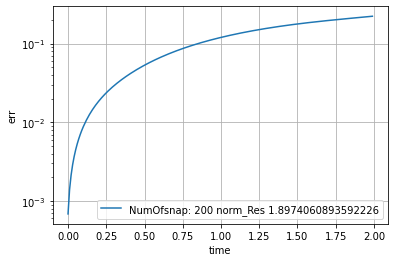

In [10]:
Mstarh = MN + dth*AN
Mstarhinv = np.linalg.inv(Mstarh)
for i in range(numsnap):
    
    res_N = fN-AN.dot(uN)
    uN += dth*Mstarhinv.dot(res_N)
    new = (uN).dot(np.transpose(V))
    
    with TaskManager():
        
        res.data = dth * f.vec - dth * a.mat * u_t_h.vec
        u_t_h.vec.data += invmstar * res               
        u_t_N.vec.FV().NumPy()[:] = new
        erg_N_snap[:,i] = u_t_N.vec
        err.vec = sqrt (Integrate ((u_t_h-u_t_N)*(u_t_h-u_t_N),mesh))
        Residium.append(err.vec)
        Time.append(i*dth)
        Redraw()
        #print(i*dth,i)
print("snap: ",numsnap,"Norm_Res: ",np.linalg.norm(Residium))

Norm_Residium.append(np.linalg.norm(Residium))
plt.semilogy(Time,Residium,label="NumOfsnap: {} norm_Res {}".format(numsnap,np.linalg.norm(Residium)))
plt.xlabel("time")
plt.ylabel("err")
plt.grid()
plt.legend()
plt.savefig("Snapshot error {} {} VS".format(numsnap,boundaries))

In [ ]:
print(Residium[50])
print(erg[:,50])

In [ ]:
print(erg[0:50,0])
print(erg_N_snap[0:50,0])

In [ ]:
print(fes.FreeDofs())

In [ ]:
for i in range(iteration):
    
    res_N = fN-AN.dot(uN)
    uN += dtN*Mstarhinv.dot(res_N)
    new = (uN).dot(np.transpose(V))
    
    with TaskManager():
        
        res.data = dtN * f.vec - dtN * a.mat * u_t_h.vec
        u_t_h.vec.data += invmstar * res               
        u_t_N.vec.FV().NumPy()[:] = new
        err.vec = sqrt (Integrate ((u_t_h-u_t_N)*(u_t_h-u_t_N),mesh))
        Residium.append(err.vec)
        Time.append(i*dtN)
        Redraw()
print("snap: ",numsnap,"Norm_Res: ",np.linalg.norm(Residium))

Norm_Residium.append(np.linalg.norm(Residium))
plt.semilogy(Time,Residium,label="NumOfsnap: {} norm_Res {}".format(numsnap,np.linalg.norm(Residium)))
plt.xlabel("time")
plt.ylabel("err")
plt.grid()
plt.legend()
plt.savefig("total error {} {} VS".format(numsnap,boundaries))